# Classification of Ovarian Tumour Conditions using a 2D dataset.
## Based on the dataset paper: https://arxiv.org/pdf/2207.06799.pdf
Uses a mix of Config mode and python API mode from mmClassification Library :
https://github.com/open-mmlab/mmclassification. <br>
Notebook solution by Oakleigh Weekes, University of Lincoln.

In [110]:
data = "/workspace/ovarianProject/OTU_2d"
import os

## Look at the dataset distribution

In [2]:
#Dataset Qualities
import os
print("Dataset Size:", len(os.listdir("/workspace/ovarianProject/OTU_2d/images")))

with open('/workspace/ovarianProject/OTU_2d/train_cls.txt') as f:
  trainContent = f.readlines()
with open('/workspace/ovarianProject/OTU_2d/val_cls.txt') as f:
  testContent = f.readlines()

print("Training Size:", len(trainContent),"|","Testing Size:", len(testContent))

Dataset Size: 1469
Training Size: 1000 | Testing Size: 469


Class Imbalances


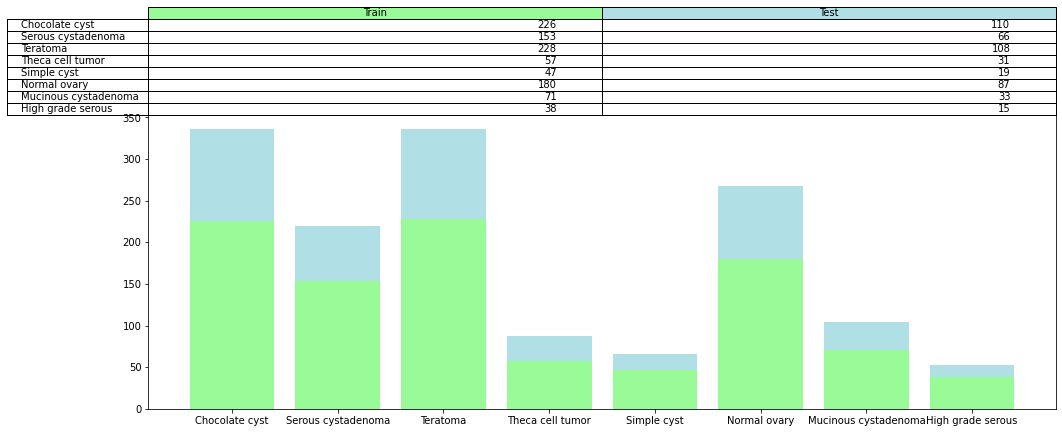

In [3]:
#Classes
# importing packages and modules
import numpy as np
import matplotlib.pyplot as plt

classNames = {
  0: "Chocolate cyst",
  1: "Serous cystadenoma",
  2: "Teratoma",
  3: "Theca cell tumor",
  4: "Simple cyst",
  5: "Normal ovary",
  6: "Mucinous cystadenoma",
  7: "High grade serous"
}

#get labels from text files
trainLabels = []
testLabels = []
for i in trainContent:
  trainLabels.append(int(i.split(" ")[2][0]))

for i in testContent:
  testLabels.append(int(i.split(" ")[2][0]))


from collections import Counter

#count each
trainClassCounts = Counter(trainLabels)
testClassCounts = Counter(testLabels)

classData = []

#add data to table
for i in range(0,len(classNames)):
  classData.append([trainClassCounts.get(i),testClassCounts.get(i)])

cols = ('Train','Test')
rows = [x for x in classNames.values()]

plt.figure(figsize=(18, 6))


plt.bar(classNames.values(), [x[0] for x in classData], color='palegreen')
plt.bar(classNames.values(), [x[1] for x in classData], bottom=[x[0] for x in classData], color='powderblue')

plt.subplots_adjust(left=0.2, bottom=0.2)
plt.table(cellText=classData,
                      rowLabels=rows,
                      colLabels=cols,
                      colColours = ['palegreen','powderblue'],
                      loc='top')
print("Class Imbalances")
plt.show()

## View samples of each class

[['641.JPG' 0]]
[['491.JPG' 1]]
[['746.JPG' 2]]
[['478.JPG' 3]]
[['44.JPG' 4]]
[['1034.JPG' 5]]
[['78.JPG' 6]]
[['1451.JPG' 7]]


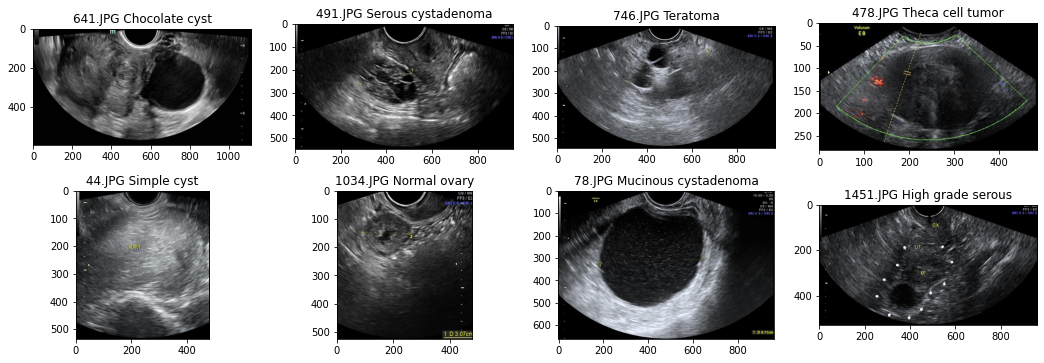

In [4]:
#Get random training sample to show from each class
import pandas as pd
train = pd.read_csv('/workspace/ovarianProject/OTU_2d/train_cls.txt',delim_whitespace=True, header=None, names=['fname','class'])
test = pd.read_csv('/workspace/ovarianProject/OTU_2d/train_cls.txt',delim_whitespace=True, header=None, names=['fname','class'])

plt.figure(figsize=(18, 6))
for i in range(0,len(classNames)):
  plt.subplot(2,4,i+1)
  cls = train[train['class']==i]
  samp = cls.sample(n=1)
  print(samp.values)
  fname = str(samp['fname'].values[0])
  p = '/workspace/ovarianProject/OTU_2d/images/' + fname
  im = plt.imread(p)
  plt.imshow(im)
  plt.title(fname + " " + classNames.get(i))

#rewrite training txt files to include path names
train['fname'] = train['fname'].apply(lambda x: '/workspace/ovarianProject/OTU_2d/images/' + x)
test['fname'] = test['fname'].apply(lambda x: '/workspace/ovarianProject/OTU_2d/images/' + x)

#Show one of each

In [7]:
#write to new train/test txt files
tfile = open('/workspace/ovarianProject/OTU_2d/newtrain.txt', 'w')
tfile.write(train.to_string(header=None,index=False))
tfile.close()

tfile = open('/workspace/ovarianProject/OTU_2d/newtest.txt', 'w')
tfile.write(test.to_string(header=None,index=False))
tfile.close()

In [5]:
import torch
print(torch.cuda.is_available())

True


# Swin Transformer v2
https://arxiv.org/pdf/2111.09883.pdf <br>
A new (2022) transformer-based deep neural network model using sliding windows
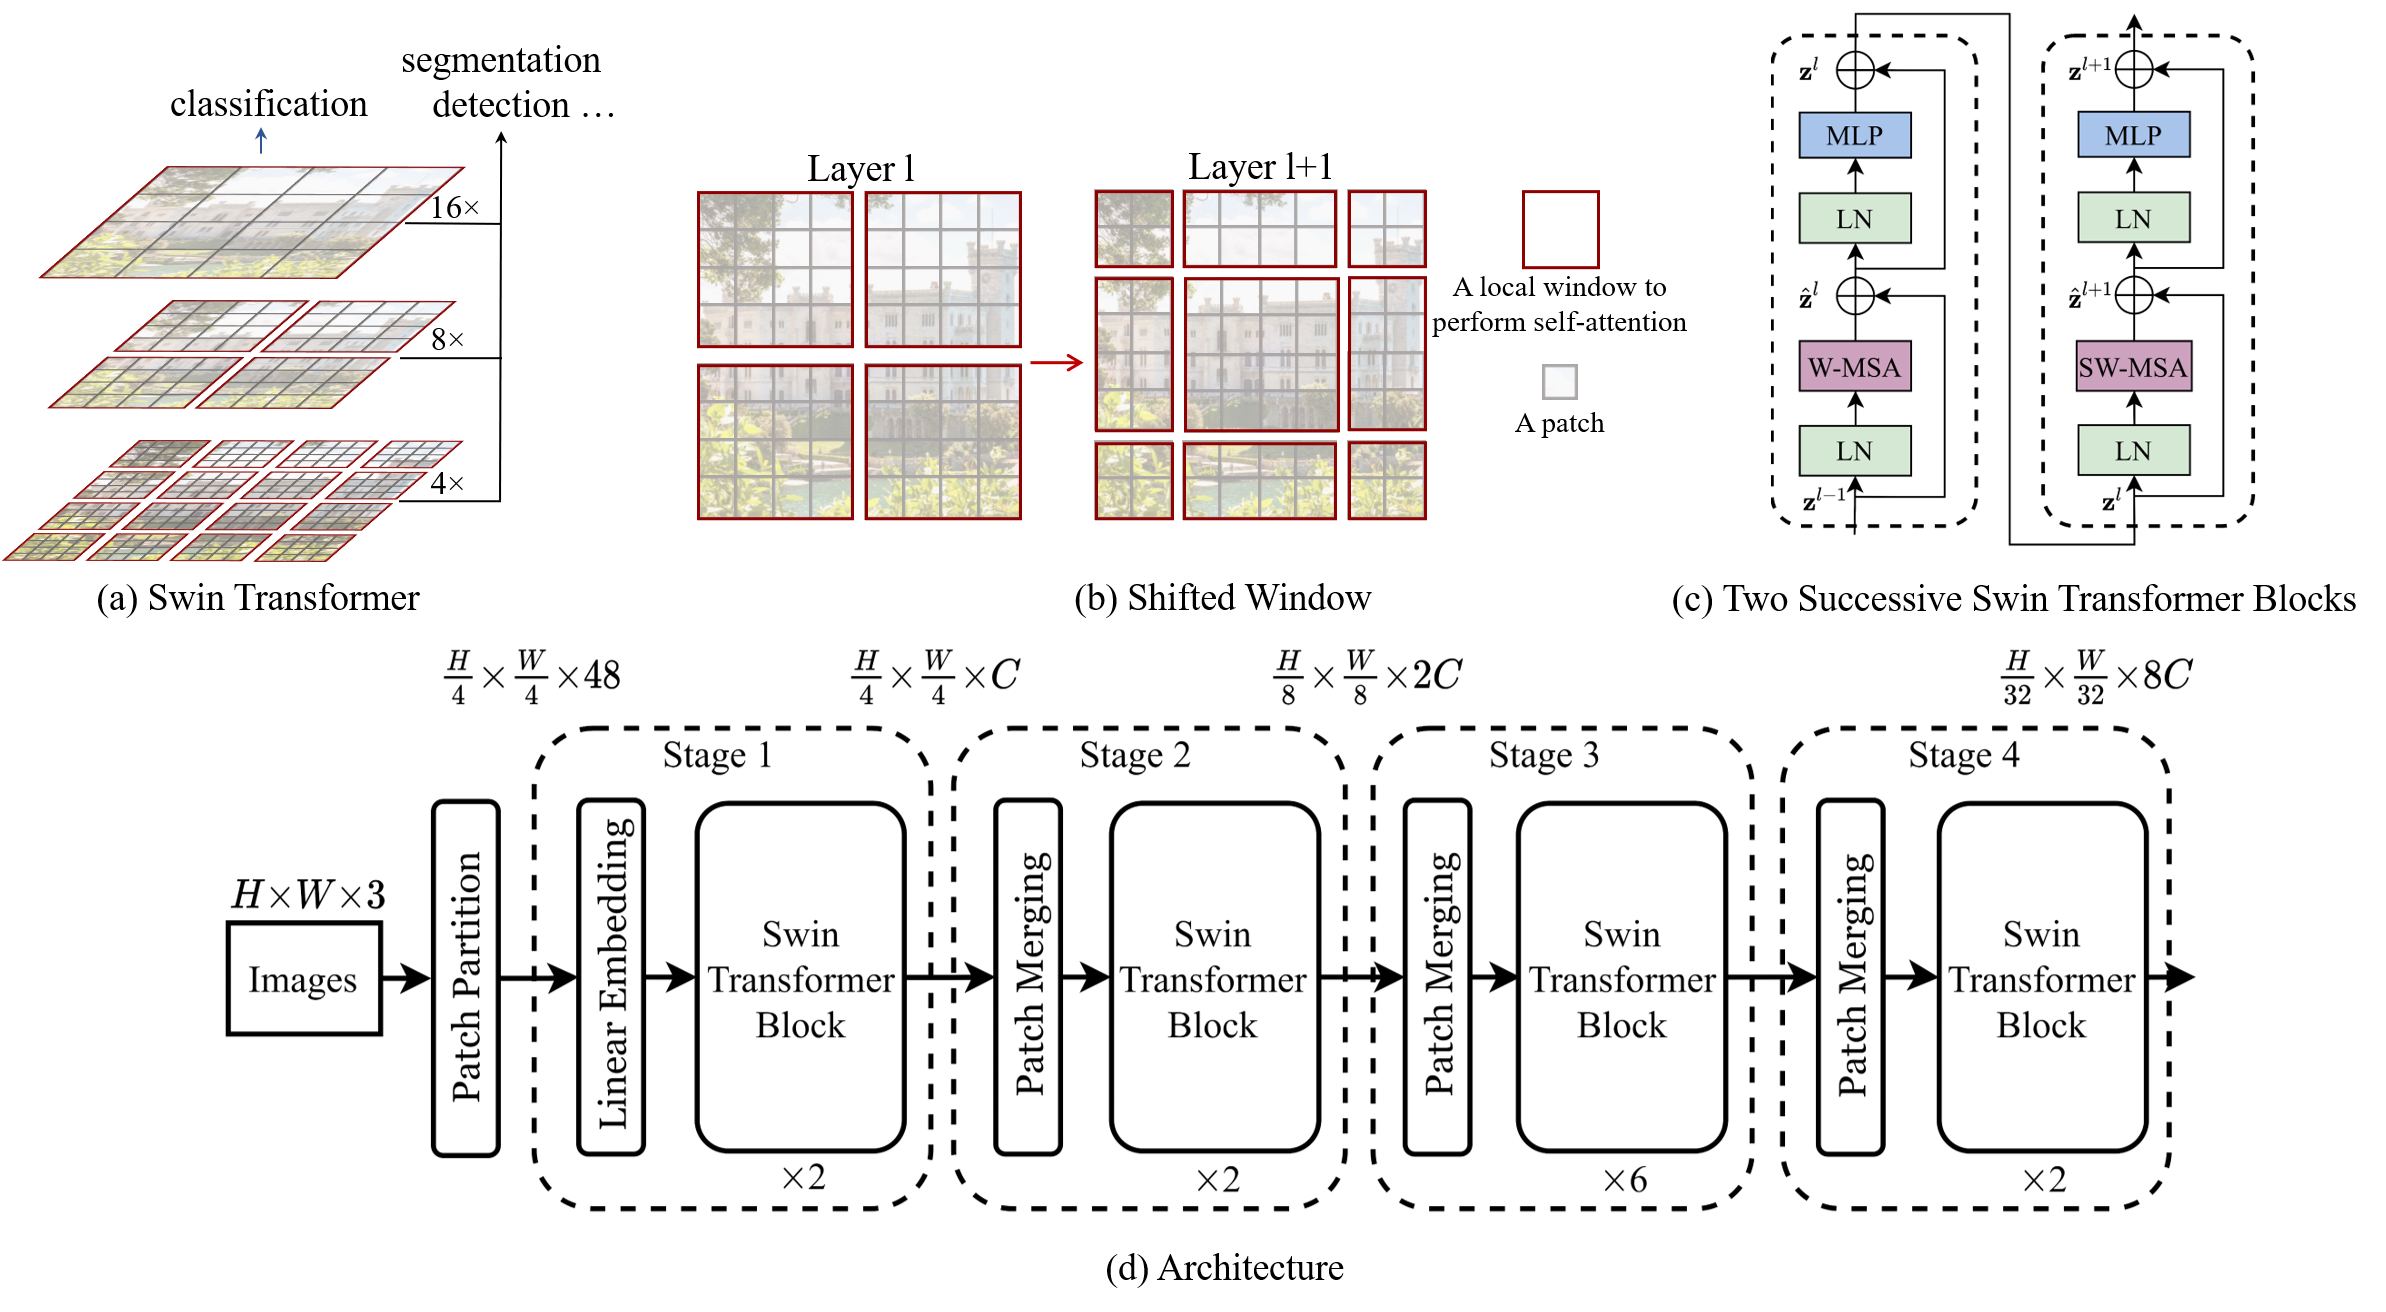

## Import Config

In [99]:
%%writefile /workspace/ovarianProject/OTU_2d/mmclassification/configs/swin_transformer_v2/swin_v2__ovarian_classification.py
_base_ = [
    '/workspace/ovarianProject/OTU_2d/mmclassification/configs/_base_/models/swin_transformer_v2/base_256.py',
    '/workspace/ovarianProject/OTU_2d/mmclassification/configs/_base_/schedules/imagenet_bs1024_adamw_swin.py',
    '/workspace/ovarianProject/OTU_2d/mmclassification/configs/_base_/default_runtime.py'
]

# ---- model settings ----
# Here we use init_cfg to load pre-trained model.
# In this way, only the weights of backbone will be loaded.
# And modify the num_classes to match our dataset.

model = dict(
    backbone=dict(
        window_size=[14, 14, 14, 7],
        init_cfg = dict(
            type='Pretrained', 
            checkpoint="https://download.openmmlab.com/mmclassification/v0/swin-transformer/swin_small_224_b16x64_300e_imagenet_20210615_110219-7f9d988b.pth", 
            prefix='backbone')
    ),
    head=dict(num_classes=8))

# ---- data settings ----
# We re-organized the dataset as `CustomDataset` format.
dataset_type = 'CustomDataset'
data_preprocessor = dict(
    mean=[124.508, 116.050, 106.438],
    std=[58.577, 57.310, 57.437],
    to_rgb=True,
    num_classes=8,
)


# ---- schedule settings ----
# Usually in fine-tuning, we need a smaller learning rate and less training epochs.
# Specify the learning rate

# Set the learning rate scheduler
param_scheduler = dict(type='StepLR', by_epoch=True, step_size=1, gamma=0.1,_delete_=True)


# ---- runtime settings ----
# Output training log every 10 iterations.
default_hooks = dict(logger=dict(interval=10))

# If you want to ensure reproducibility, set a random seed. And enable the
# deterministic option in cuDNN to further ensure reproducibility, but it may
# reduce the training speed.
randomness = dict(seed=1, deterministic=False)

Overwriting /workspace/ovarianProject/OTU_2d/mmclassification/configs/swin_transformer_v2/swin_v2__ovarian_classification.py


In [100]:
%cd /workspace/ovarianProject/OTU_2d/mmclassification

/workspace/ovarianProject/OTU_2d/mmclassification


## Create Trainer

In [101]:
from mmengine import Config, ConfigDict
from mmengine.runner import Runner

base_cfg = Config.fromfile('/workspace/ovarianProject/OTU_2d/mmclassification/configs/swin_transformer_v2/swin_v2__ovarian_classification.py')

# ------ model settings ------
# Modify the number of classes in the head.
model = base_cfg.model
model.head.num_classes = 8

train_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(type='RandomResizedCrop', scale=224, backend='pillow'),
    dict(type='RandomFlip', prob=0.5, direction='horizontal'),
    dict(type='PackClsInputs'),
]
test_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(type='ResizeEdge', scale=256, edge='short', backend='pillow'),
    dict(type='CenterCrop', crop_size=224),
    dict(type='PackClsInputs'),
]

train_dataloader = dict(
    batch_size=16,
    num_workers=2,
    dataset=dict(
        type='CustomDataset',
        data_root = '/workspace/ovarianProject/OTU_2d',
        data_prefix = '/images',
        ann_file='newtrain.txt',
        classes=["Chocolate cyst","Serous cystadenoma","Teratoma","Theca cell tumor","Simple cyst","Normal ovary","Mucinous cystadenoma","High grade serous"],
        pipeline=train_pipeline,
    ),
    sampler=dict(type='DefaultSampler', shuffle=True),
)

val_dataloader = dict(
    batch_size=16,
    num_workers=2,
    dataset=dict(
        type='CustomDataset',
        data_root = '/workspace/ovarianProject/OTU_2d',
        data_prefix = '/images',
        ann_file='newtest.txt',  
        classes=["Chocolate cyst","Serous cystadenoma","Teratoma","Theca cell tumor","Simple cyst","Normal ovary","Mucinous cystadenoma","High grade serous"],
        pipeline=test_pipeline,
    ),
    sampler=dict(type='DefaultSampler', shuffle=False),
)

# Specify the optimizer
optim_wrapper = dict(
    optimizer=dict(type='SGD', lr=0.005, momentum=0.9, weight_decay=0.0001),
    clip_grad=None,
)

train_cfg = dict(by_epoch=True, max_epochs=30,val_interval=1)
val_cfg = dict()
test_cfg = dict()


val_evaluator = dict(type='Accuracy', topk=1)
test_evaluator = val_evaluator


data_preprocessor = dict(
    mean=[124.508, 116.050, 106.438],
    std=[58.577, 57.310, 57.437],
    to_rgb=True,
    num_classes=8,
)

runner = Runner(
    # Common settings
    model=model,
    default_scope='mmcls',
    data_preprocessor =data_preprocessor,
    train_cfg=train_cfg,
    val_cfg=val_cfg,
    optim_wrapper=optim_wrapper,
    train_dataloader=train_dataloader,
    val_dataloader=val_dataloader,
    val_evaluator=val_evaluator,
    work_dir="/workspace/ovarianProject/OTU_2d/work_dirs/swin_transformer_v2_ovarian_classification",
    experiment_name='swin_v2__ovarian_classification1',
)

03/11 13:28:52 - mmengine - INFO - 
------------------------------------------------------------
System environment:
    sys.platform: linux
    Python: 3.7.13 (default, Mar 29 2022, 02:18:16) [GCC 7.5.0]
    CUDA available: True
    numpy_random_seed: 2136801560
    GPU 0: TITAN V
    CUDA_HOME: None
    GCC: n/a
    PyTorch: 1.12.0
    PyTorch compiling details: PyTorch built with:
  - GCC 9.3
  - C++ Version: 201402
  - Intel(R) oneAPI Math Kernel Library Version 2021.4-Product Build 20210904 for Intel(R) 64 architecture applications
  - Intel(R) MKL-DNN v2.6.0 (Git Hash 52b5f107dd9cf10910aaa19cb47f3abf9b349815)
  - OpenMP 201511 (a.k.a. OpenMP 4.5)
  - LAPACK is enabled (usually provided by MKL)
  - NNPACK is enabled
  - CPU capability usage: AVX2
  - CUDA Runtime 11.3
  - NVCC architecture flags: -gencode;arch=compute_37,code=sm_37;-gencode;arch=compute_50,code=sm_50;-gencode;arch=compute_60,code=sm_60;-gencode;arch=compute_61,code=sm_61;-gencode;arch=compute_70,code=sm_70;-gencod

/bin/sh: 1: gcc: not found


03/11 13:28:53 - mmengine - INFO - Distributed training is not used, all SyncBatchNorm (SyncBN) layers in the model will be automatically reverted to BatchNormXd layers if they are used.
03/11 13:28:53 - mmengine - INFO - Hooks will be executed in the following order:
before_run:
(VERY_HIGH   ) RuntimeInfoHook                    
(BELOW_NORMAL) LoggerHook                         
 -------------------- 
before_train:
(VERY_HIGH   ) RuntimeInfoHook                    
(NORMAL      ) IterTimerHook                      
(VERY_LOW    ) CheckpointHook                     
 -------------------- 
before_train_epoch:
(VERY_HIGH   ) RuntimeInfoHook                    
(NORMAL      ) IterTimerHook                      
(NORMAL      ) DistSamplerSeedHook                
 -------------------- 
before_train_iter:
(VERY_HIGH   ) RuntimeInfoHook                    
(NORMAL      ) IterTimerHook                      
 -------------------- 
after_train_iter:
(VERY_HIGH   ) RuntimeInfoHook                

## Train

In [102]:
model = runner.train()

03/11 13:28:58 - mmengine - INFO - load backbone in model from: https://download.openmmlab.com/mmclassification/v0/swin-transformer/swin_small_224_b16x64_300e_imagenet_20210615_110219-7f9d988b.pth
Loads checkpoint by http backend from path: https://download.openmmlab.com/mmclassification/v0/swin-transformer/swin_small_224_b16x64_300e_imagenet_20210615_110219-7f9d988b.pth
03/11 13:28:58 - mmengine - INFO - Delete `relative_position_index` and `relative_coords_table` since we always re-init these params according to the `window_size`, which might cause unwanted but unworried warnings when loading checkpoint.
03/11 13:28:58 - mmengine - WARNING - The model and loaded state dict do not match exactly

size mismatch for patch_embed.projection.weight: copying a param with shape torch.Size([96, 3, 4, 4]) from checkpoint, the shape in current model is torch.Size([128, 3, 4, 4]).
size mismatch for patch_embed.projection.bias: copying a param with shape torch.Size([96]) from checkpoint, the shape

## Functions for plotting metrics

In [105]:
import json
from collections import defaultdict
import matplotlib.pyplot as plt

def load_json_log(json_log):
    """load and convert json_logs to log_dicts.
    Args:
        json_log (str): The path of the json log file.
    Returns:
        dict[int, dict[str, list]]:
            Key is the epoch, value is a sub dict. The keys in each sub dict
            are different metrics, e.g. memory, bbox_mAP, and the value is a
            list of corresponding values in all iterations in this epoch.
            .. code-block:: python
                # An example output
                {
                    1: {'iter': [100, 200, 300], 'loss': [6.94, 6.73, 6.53]},
                    2: {'iter': [100, 200, 300], 'loss': [6.33, 6.20, 6.07]},
                    ...
                }
    """
    log_dict = dict()
    with open(json_log, 'r') as log_file:
        accuracies = []
        for line in log_file:
            log = json.loads(line.strip())
            # skip lines without `epoch` field
            if 'epoch' not in log:
                if 'accuracy/top1' in log:
                    losses.append(log['accuracy/top1'])
                    accuracies.append(log['accuracy/top1'])
                continue
            epoch = log.pop('epoch')
            if epoch not in log_dict:
                log_dict[epoch] = defaultdict(list)
            for k, v in log.items():
                log_dict[epoch][k].append(v)
    return log_dict, accuracies

def log_plot(path):
    log_dict,acc = load_json_log(path)
    losses = []
    for i in range(1,len(log_dict)+1):
        losses.append(log_dict.get(i)['loss'][-1])

    plt.figure()
    plt.figure(figsize=(18, 6))
    plt.subplot(1,2,1)
    epochs = range(1,len(log_dict)+1)
    plt.plot(epochs,losses)
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.locator_params(axis="x", integer=True)
    plt.legend(['Loss'])
    plt.title("Loss vs Epoch")

    plt.subplot(1,2,2)
    plt.plot(epochs,acc)
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.locator_params(axis="x", integer=True)
    plt.legend('Validation Accuracy')
    plt.legend(['Val Accuracy'])
    plt.title("Validation Accuracy vs Epoch")

## Plot training loss and Validation Accuracy

<Figure size 432x288 with 0 Axes>

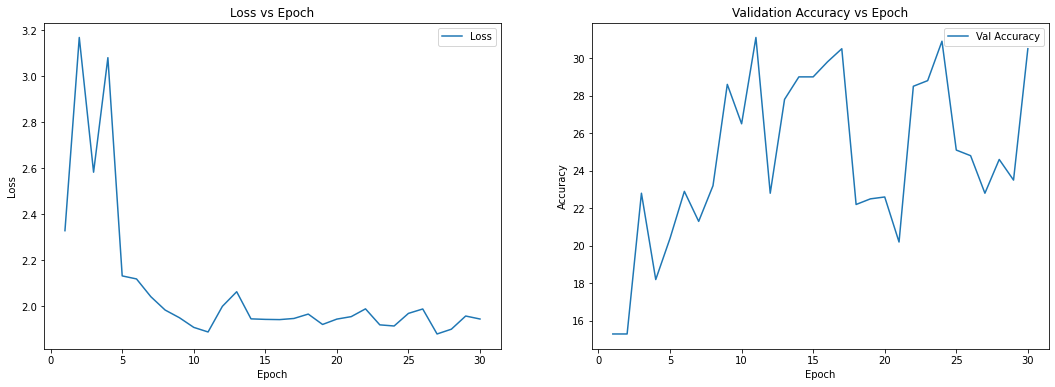

In [109]:
log_plot("/workspace/ovarianProject/OTU_2d/work_dirs/swin_transformer_v2_ovarian_classification/20230311_132852/vis_data/scalars.json")

# MobileNet v2
https://arxiv.org/pdf/1801.04381.pdf <br>
A comparably lightweight convolutional neural network (2019) 
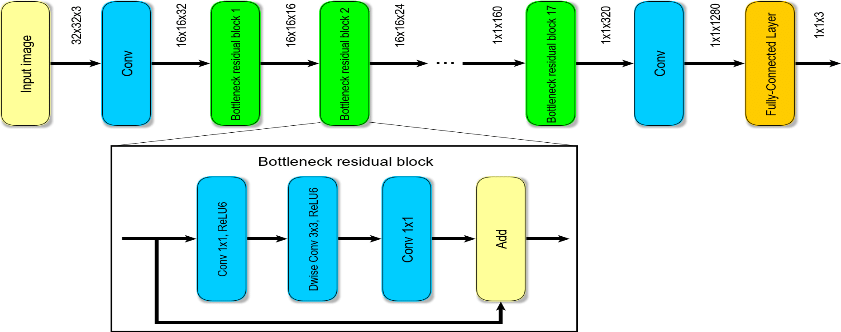

## Import Config

In [123]:
%%writefile /workspace/ovarianProject/OTU_2d/mmclassification/configs/mobilenet_v2/mobilenet_v2__ovarian_classification.py
_base_ = [
    '/workspace/ovarianProject/OTU_2d/mmclassification/configs/_base_/models/mobilenet_v2_1x.py',
    '/workspace/ovarianProject/OTU_2d/mmclassification/configs/_base_/schedules/imagenet_bs256_epochstep.py',
    '/workspace/ovarianProject/OTU_2d/mmclassification/configs/_base_/default_runtime.py'
]

# ---- model settings ----
# Here we use init_cfg to load pre-trained model.
# In this way, only the weights of backbone will be loaded.
# And modify the num_classes to match our dataset.

model = dict(
    backbone=dict(
        init_cfg = dict(
            type='Pretrained', 
            checkpoint='https://download.openmmlab.com/mmclassification/v0/mobilenet_v2/mobilenet_v2_batch256_imagenet_20200708-3b2dc3af.pth', 
            prefix='backbone')
    ),
    head=dict(num_classes=8))

test_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(type='ResizeEdge', scale=256, edge='short', backend='pillow'),
    dict(type='CenterCrop', crop_size=224),
    dict(type='PackClsInputs'),
]

# ---- data settings ----
# We re-organized the dataset as `CustomDataset` format.
dataset_type = 'CustomDataset'
data_preprocessor = dict(
    mean=[124.508, 116.050, 106.438],
    std=[58.577, 57.310, 57.437],
    to_rgb=True,
)

test_dataloader = dict(
    batch_size=32,
    num_workers=2,
    dataset=dict(
        data_root = '/workspace/ovarianProject/OTU_2d', 
        type=dataset_type,
        classes=["Chocolate cyst","Serous cystadenoma","Teratoma","Theca cell tumor","Simple cyst","Normal ovary","Mucinous cystadenoma","High grade serous"],
        pipeline=test_pipeline,
    ),
    sampler=dict(type='DefaultSampler', shuffle=False),
)

# ---- schedule settings ----
# Set the learning rate scheduler
param_scheduler = dict(type='StepLR', by_epoch=True, step_size=1, gamma=0.1)


# ---- runtime settings ----
# Output training log every 10 iterations.
default_hooks = dict(logger=dict(interval=10))

# If you want to ensure reproducibility, set a random seed. And enable the
# deterministic option in cuDNN to further ensure reproducibility, but it may
# reduce the training speed.
randomness = dict(seed=0, deterministic=False)

Overwriting /workspace/ovarianProject/OTU_2d/mmclassification/configs/mobilenet_v2/mobilenet_v2__ovarian_classification.py


## Create Trainer

In [112]:
from mmengine import Config, ConfigDict
from mmengine.runner import Runner

base_cfg = Config.fromfile('/workspace/ovarianProject/OTU_2d/mmclassification/configs/mobilenet_v2/mobilenet_v2__ovarian_classification.py')

# ------ model settings ------
# Modify the number of classes in the head.
model = base_cfg.model
model.head.num_classes = 8

train_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(type='RandomResizedCrop', scale=224, backend='pillow'),
    dict(type='RandomFlip', prob=0.5, direction='horizontal'),
    dict(type='PackClsInputs'),
]
test_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(type='ResizeEdge', scale=256, edge='short', backend='pillow'),
    dict(type='CenterCrop', crop_size=224),
    dict(type='PackClsInputs'),
]

train_dataloader = dict(
    batch_size=16,
    num_workers=2,
    dataset=dict(
        type='CustomDataset',
        data_root = '/workspace/ovarianProject/OTU_2d',
        data_prefix = '/images',
        ann_file='newtrain.txt',
        classes=["Chocolate cyst","Serous cystadenoma","Teratoma","Theca cell tumor","Simple cyst","Normal ovary","Mucinous cystadenoma","High grade serous"],
        pipeline=train_pipeline,
    ),
    sampler=dict(type='DefaultSampler', shuffle=True),
)

val_dataloader = dict(
    batch_size=16,
    num_workers=2,
    dataset=dict(
        type='CustomDataset',
        data_root = '/workspace/ovarianProject/OTU_2d',
        data_prefix = '/images',
        ann_file='newtest.txt',  
        classes=["Chocolate cyst","Serous cystadenoma","Teratoma","Theca cell tumor","Simple cyst","Normal ovary","Mucinous cystadenoma","High grade serous"],
        pipeline=test_pipeline,
    ),
    sampler=dict(type='DefaultSampler', shuffle=False),
)

# Specify the optimizer
optim_wrapper = dict(
    optimizer=dict(type='SGD', lr=0.005, momentum=0.9, weight_decay=0.0001),
    clip_grad=None,
)

train_cfg = dict(by_epoch=True, max_epochs=30,val_interval=1)
val_cfg = dict()
test_cfg = dict()


val_evaluator = dict(type='Accuracy', topk=1)
test_evaluator = val_evaluator


data_preprocessor = dict(
    mean=[124.508, 116.050, 106.438],
    std=[58.577, 57.310, 57.437],
    to_rgb=True,
    num_classes=8,
)

runner = Runner(
    # Common settings
    model=model,
    default_scope='mmcls',
    data_preprocessor =data_preprocessor,
    train_cfg=train_cfg,
    val_cfg=val_cfg,
    optim_wrapper=optim_wrapper,
    train_dataloader=train_dataloader,
    val_dataloader=val_dataloader,
    val_evaluator=val_evaluator,
    work_dir="/workspace/ovarianProject/OTU_2d/work_dirs/mobileNet_v2_ovarian_classification",
    experiment_name='mobileNet_v2__ovarian_classification1',
)

03/11 14:07:36 - mmengine - INFO - 
------------------------------------------------------------
System environment:
    sys.platform: linux
    Python: 3.7.13 (default, Mar 29 2022, 02:18:16) [GCC 7.5.0]
    CUDA available: True
    numpy_random_seed: 1946294444
    GPU 0: TITAN V
    CUDA_HOME: None
    GCC: n/a
    PyTorch: 1.12.0
    PyTorch compiling details: PyTorch built with:
  - GCC 9.3
  - C++ Version: 201402
  - Intel(R) oneAPI Math Kernel Library Version 2021.4-Product Build 20210904 for Intel(R) 64 architecture applications
  - Intel(R) MKL-DNN v2.6.0 (Git Hash 52b5f107dd9cf10910aaa19cb47f3abf9b349815)
  - OpenMP 201511 (a.k.a. OpenMP 4.5)
  - LAPACK is enabled (usually provided by MKL)
  - NNPACK is enabled
  - CPU capability usage: AVX2
  - CUDA Runtime 11.3
  - NVCC architecture flags: -gencode;arch=compute_37,code=sm_37;-gencode;arch=compute_50,code=sm_50;-gencode;arch=compute_60,code=sm_60;-gencode;arch=compute_61,code=sm_61;-gencode;arch=compute_70,code=sm_70;-gencod

/bin/sh: 1: gcc: not found


In [113]:
model = runner.train()

03/11 14:07:46 - mmengine - INFO - load backbone in model from: https://download.openmmlab.com/mmclassification/v0/mobilenet_v2/mobilenet_v2_batch256_imagenet_20200708-3b2dc3af.pth
Loads checkpoint by http backend from path: https://download.openmmlab.com/mmclassification/v0/mobilenet_v2/mobilenet_v2_batch256_imagenet_20200708-3b2dc3af.pth


Downloading: "https://download.openmmlab.com/mmclassification/v0/mobilenet_v2/mobilenet_v2_batch256_imagenet_20200708-3b2dc3af.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2_batch256_imagenet_20200708-3b2dc3af.pth


03/11 14:07:47 - mmengine - INFO - Checkpoints will be saved to /workspace/ovarianProject/OTU_2d/work_dirs/mobileNet_v2_ovarian_classification.
03/11 14:07:48 - mmengine - INFO - Epoch(train)  [1][10/63]  lr: 5.0000e-03  eta: 0:04:39  time: 0.1487  data_time: 0.0803  memory: 1527  loss: 1.9680
03/11 14:07:49 - mmengine - INFO - Epoch(train)  [1][20/63]  lr: 5.0000e-03  eta: 0:03:40  time: 0.0871  data_time: 0.0458  memory: 1242  loss: 1.9796
03/11 14:07:50 - mmengine - INFO - Epoch(train)  [1][30/63]  lr: 5.0000e-03  eta: 0:03:25  time: 0.0959  data_time: 0.0468  memory: 1242  loss: 1.9307
03/11 14:07:51 - mmengine - INFO - Epoch(train)  [1][40/63]  lr: 5.0000e-03  eta: 0:03:14  time: 0.0892  data_time: 0.0391  memory: 1242  loss: 1.8723
03/11 14:07:52 - mmengine - INFO - Epoch(train)  [1][50/63]  lr: 5.0000e-03  eta: 0:03:09  time: 0.0945  data_time: 0.0472  memory: 1242  loss: 2.2726
03/11 14:07:53 - mmengine - INFO - Epoch(train)  [1][60/63]  lr: 5.0000e-03  eta: 0:03:04  time: 0.08

## Plot training loss and Validation Accuracy

<Figure size 432x288 with 0 Axes>

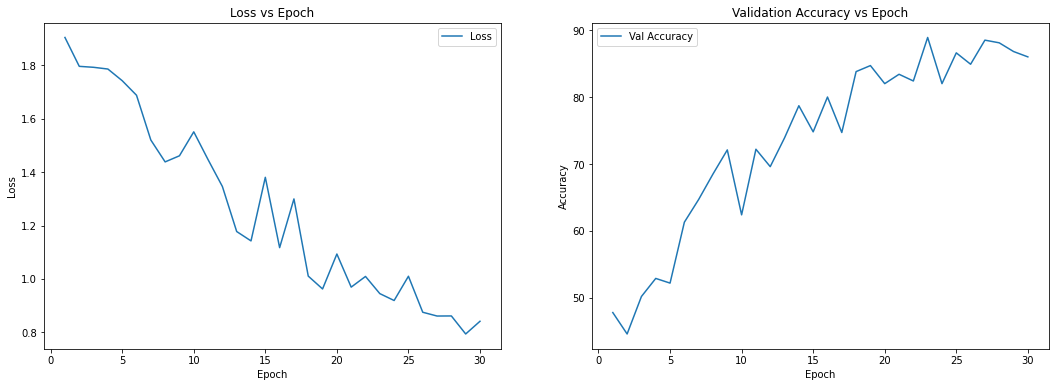

In [115]:
log_plot("/workspace/ovarianProject/OTU_2d/work_dirs/mobileNet_v2_ovarian_classification/20230311_140736/vis_data/scalars.json")

## Therefore MobileNetv2 (Acc 86%) wins over Swin Transformer v2 (Acc 30.5%)

# Assessing Model Accuracy on the Validation Dataset

## Predict

In [127]:
#What was classified correctly and incorrectly in the validation dataset?
from mmcls.apis import inference_model, init_model
from mmcls.utils import register_all_modules
from mmengine.fileio import dump
from rich import print_json

testing = test['fname'].values
gt = test['class'].values

# build the model from a config file and a checkpoint file
model = init_model("/workspace/ovarianProject/OTU_2d/mmclassification/configs/mobilenet_v2/mobilenet_v2__ovarian_classification.py", "/workspace/ovarianProject/OTU_2d/work_dirs/mobileNet_v2_ovarian_classification/epoch_30.pth")

preds = []
for im in testing:
    # register all modules and set mmcls as the default scope.
    register_all_modules() 
    # test a single image
    result = inference_model(model, im)
    res_json = dump(result, file_format='json', indent=4)
    # show the results
    #preds.append(result["pred_class"])
    preds.append(result["pred_label"])

Loads checkpoint by local backend from path: /workspace/ovarianProject/OTU_2d/work_dirs/mobileNet_v2_ovarian_classification/epoch_30.pth


## Show Confusion Matrix

Text(69.0, 0.5, 'True Label')

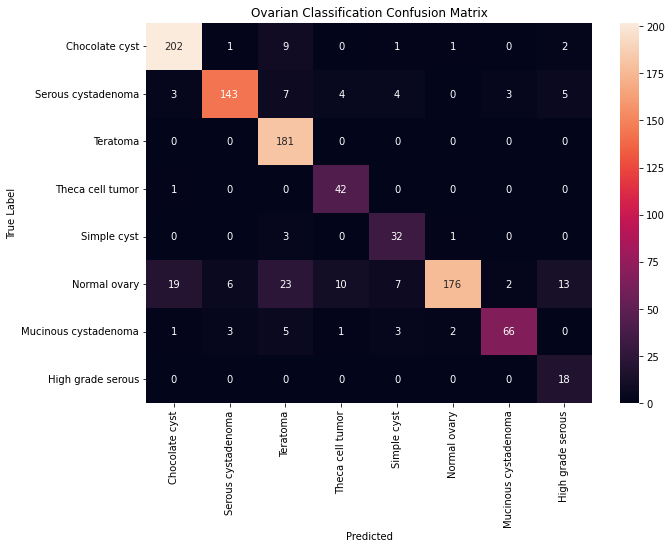

In [137]:
import seaborn as sn
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix

#confusion matrix
classLabels = classNames.values()
the_matrix = confusion_matrix(preds, gt, labels=list(classNames.keys()))

df_cfm = pd.DataFrame(the_matrix, index = classLabels, columns = classLabels)
plt.figure(figsize = (10,7))
cfm_plot = sn.heatmap(df_cfm, annot=True, fmt='g')
cfm_plot.set_title("Ovarian Classification Confusion Matrix")
cfm_plot.set_xlabel('Predicted')
cfm_plot.set_ylabel('True Label')

On viewing the confusion matrix, The validation set has a good classification rate. However, it seems to misclassify normal ovary considerably, as chocolate cyst, teratoma and high-grade serous. This would result in the clinician being alerted to this and have to give a second opinion. Luckily, the converse is quite low, as 4 abnormalities are incorrectly classified as normal. This would be the metric that would be of utmost importance to bring to 0.

# Using GradCam to assess how the model learned

/workspace/ovarianProject/OTU_2d/images/1165.JPG
/workspace/ovarianProject/OTU_2d/images/617.JPG
/workspace/ovarianProject/OTU_2d/images/1087.JPG
/workspace/ovarianProject/OTU_2d/images/1187.JPG
/workspace/ovarianProject/OTU_2d/images/1375.JPG
/workspace/ovarianProject/OTU_2d/images/202.JPG
/workspace/ovarianProject/OTU_2d/images/697.JPG
/workspace/ovarianProject/OTU_2d/images/1437.JPG


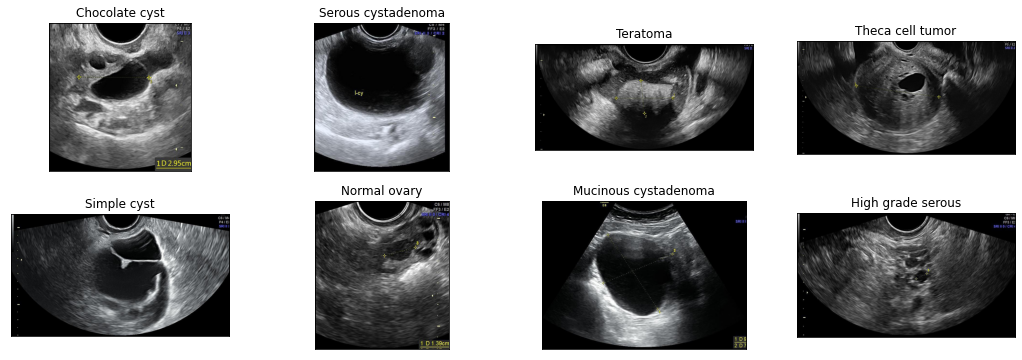

In [138]:
plt.figure(figsize=(18, 6))
#get random samples from validation to test gradcam on

to_examine = []
for i in range(0,len(classNames)):
  plt.subplot(2,4,i+1)
  cls = test[test['class']==i]
  samp = cls.sample(n=1)
  print(samp.values[0][0])
  to_examine.append(samp.values[0][0])
  fname = str(samp['fname'].values[0])
  im = plt.imread(fname)
  plt.imshow(im)
  plt.xticks([])
  plt.yticks([])
  plt.title(classNames.get(i))

In [139]:
chocolateCyst = to_examine[0]
serousCystadenoma = to_examine[1]
teratoma = to_examine[2]
thecaCellTumor = to_examine[3]
simpleCyst = to_examine[4]
normalOvary= to_examine[5]
mucsinousCystadenoma = to_examine[6]
highGradeSerous= to_examine[7]

In [141]:
!python tools/visualizations/vis_cam.py \
    $chocolateCyst \
    /workspace/ovarianProject/OTU_2d/mmclassification/configs/mobilenet_v2/mobilenet_v2__ovarian_classification.py \
    /workspace/ovarianProject/OTU_2d/work_dirs/mobileNet_v2_ovarian_classification/epoch_30.pth \
    --method GradCAM \
    --save-path /workspace/ovarianProject/OTU_2d/gradCam_output/chocolateCyst.jpg

!python tools/visualizations/vis_cam.py \
    $serousCystadenoma \
    /workspace/ovarianProject/OTU_2d/mmclassification/configs/mobilenet_v2/mobilenet_v2__ovarian_classification.py \
    /workspace/ovarianProject/OTU_2d/work_dirs/mobileNet_v2_ovarian_classification/epoch_30.pth \
    --method GradCAM \
    --save-path /workspace/ovarianProject/OTU_2d/gradCam_output/serousCystadenoma.jpg

!python tools/visualizations/vis_cam.py \
    $teratoma \
    /workspace/ovarianProject/OTU_2d/mmclassification/configs/mobilenet_v2/mobilenet_v2__ovarian_classification.py \
    /workspace/ovarianProject/OTU_2d/work_dirs/mobileNet_v2_ovarian_classification/epoch_30.pth \
    --method GradCAM \
    --save-path /workspace/ovarianProject/OTU_2d/gradCam_output/teratoma.jpg

!python tools/visualizations/vis_cam.py \
    $thecaCellTumor \
    /workspace/ovarianProject/OTU_2d/mmclassification/configs/mobilenet_v2/mobilenet_v2__ovarian_classification.py \
    /workspace/ovarianProject/OTU_2d/work_dirs/mobileNet_v2_ovarian_classification/epoch_30.pth \
    --method GradCAM \
    --save-path /workspace/ovarianProject/OTU_2d/gradCam_output/thecaCellTumor.jpg

!python tools/visualizations/vis_cam.py \
    $simpleCyst \
    /workspace/ovarianProject/OTU_2d/mmclassification/configs/mobilenet_v2/mobilenet_v2__ovarian_classification.py \
    /workspace/ovarianProject/OTU_2d/work_dirs/mobileNet_v2_ovarian_classification/epoch_30.pth \
    --method GradCAM \
    --save-path /workspace/ovarianProject/OTU_2d/gradCam_output/simpleCyst.jpg

!python tools/visualizations/vis_cam.py \
    $normalOvary \
    /workspace/ovarianProject/OTU_2d/mmclassification/configs/mobilenet_v2/mobilenet_v2__ovarian_classification.py \
    /workspace/ovarianProject/OTU_2d/work_dirs/mobileNet_v2_ovarian_classification/epoch_30.pth \
    --method GradCAM \
    --save-path /workspace/ovarianProject/OTU_2d/gradCam_output/normalOvary.jpg

!python tools/visualizations/vis_cam.py \
    $mucsinousCystadenoma \
    /workspace/ovarianProject/OTU_2d/mmclassification/configs/mobilenet_v2/mobilenet_v2__ovarian_classification.py \
    /workspace/ovarianProject/OTU_2d/work_dirs/mobileNet_v2_ovarian_classification/epoch_30.pth \
    --method GradCAM \
    --save-path /workspace/ovarianProject/OTU_2d/gradCam_output/mucinousCystadenoma.jpg

!python tools/visualizations/vis_cam.py \
    $highGradeSerous \
    /workspace/ovarianProject/OTU_2d/mmclassification/configs/mobilenet_v2/mobilenet_v2__ovarian_classification.py \
    /workspace/ovarianProject/OTU_2d/work_dirs/mobileNet_v2_ovarian_classification/epoch_30.pth \
    --method GradCAM \
    --save-path /workspace/ovarianProject/OTU_2d/gradCam_output/highGradeSerous.jpg

03/11 14:57:38 - mmengine - WARNING - The "model" registry in mmcls did not set import location. Fallback to call `mmcls.utils.register_all_modules` instead.
Loads checkpoint by local backend from path: /workspace/ovarianProject/OTU_2d/work_dirs/mobileNet_v2_ovarian_classification/epoch_30.pth
03/11 14:57:38 - mmengine - WARNING - The "transform" registry in mmcls did not set import location. Fallback to call `mmcls.utils.register_all_modules` instead.
Automatically choose the last norm layer as target_layer.
03/11 14:57:42 - mmengine - WARNING - The "model" registry in mmcls did not set import location. Fallback to call `mmcls.utils.register_all_modules` instead.
Loads checkpoint by local backend from path: /workspace/ovarianProject/OTU_2d/work_dirs/mobileNet_v2_ovarian_classification/epoch_30.pth
03/11 14:57:43 - mmengine - WARNING - The "transform" registry in mmcls did not set import location. Fallback to call `mmcls.utils.register_all_modules` instead.
Automatically choose the las

In [142]:
#view predictions on just the samples
from mmcls.apis import inference_model, init_model
from mmcls.utils import register_all_modules
from mmengine.fileio import dump
from rich import print_json

preds = []
for im in to_examine:
    # register all modules and set mmcls as the default scope.
    register_all_modules()
    # build the model from a config file and a checkpoint file
    # test a single image
    result = inference_model(model, im)
    res_json = dump(result, file_format='json', indent=4)
    # show the results
    preds.append(result["pred_class"])
    
for i in range(0,len(classNames)):
  print(classNames.get(i), "predicted as:", preds[i])

Chocolate cyst predicted as: Normal ovary
Serous cystadenoma predicted as: Serous cystadenoma
Teratoma predicted as: Teratoma
Theca cell tumor predicted as: Theca cell tumor
Simple cyst predicted as: Serous cystadenoma
Normal ovary predicted as: Normal ovary
Mucinous cystadenoma predicted as: Mucinous cystadenoma
High grade serous predicted as: Normal ovary


## Show GradCam Results

<Figure size 1728x720 with 0 Axes>

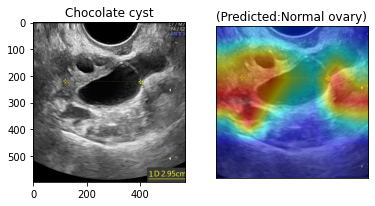

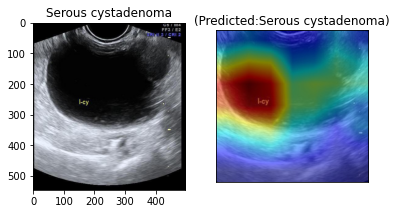

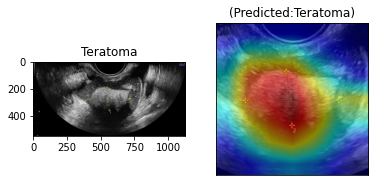

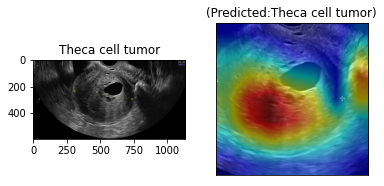

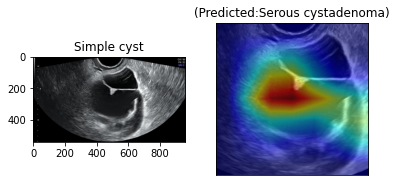

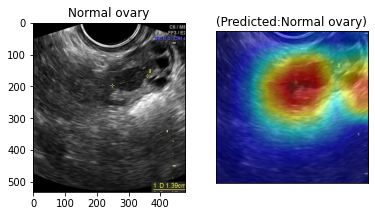

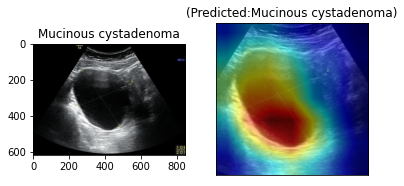

In [153]:
#function to convert from class key name to file name camelcase format
def to_camel_case(text):
  s = text.replace("-", " ").replace("_", " ")
  s = s.split()
  s = [x.lower() for x in s]
  if len(text) == 0:
    return text
  return s[0] + ''.join(i.capitalize() for i in s[1:])

plt.figure(figsize=(24, 10))
gc_results = os.listdir('/workspace/ovarianProject/OTU_2d/gradCam_output')
gc_results = [x for x in gc_results if x.endswith('.jpg')]

#plot gradcams
for i in range(0,len(gc_results)-1):
  plt.figure()
  name = list(classNames.values())[i]
  OGim = plt.imread(to_examine[i])
  plt.subplot(1,2,1)
  plt.imshow(OGim)
  plt.title(name)
  plt.subplot(1,2,2)
  imP = '/workspace/ovarianProject/OTU_2d/gradCam_output/' + to_camel_case(name) + '.jpg'
  im = plt.imread(imP)
  t = "(Predicted:" +preds[i] + ")"
  plt.title(t)
  plt.xticks([])
  plt.yticks([])
  plt.imshow(im)

Grad-cam shows the learning pattern (analyses which pixel weights are sensitive to change per class pattern). For normal ovary, it appears to classify based two seperate sections in the image. As it sees two seperate sections in the chocolate cyst image, it misclassifies.

How could we increase accuracy?
- Assess label correctness- it may be an issue with manual annotating.
- Assess noise in input images, can reduce via manual intervention or denoising pre-processing.
- Compare other models, change parameters such as learning rate, epochs, optimisations etc.
- Gain more data; either by further collection or using augmentations.
- Reduce class imbalance (by doing the former).
- Assess bands(layers) of the 3D dataset version - perform a form of principal component analysis to assess usefulness of each band to reduce training time overhead and prevent overfitting.
- Enable active learning- where the model re-classifies based on the clinicians input "this result is incorrect". It could look for the result with the next highest probabilitity, and perhaps adjust weights accordingly.
- Add a segmentation step prior to classifying, to reduce the search 'ROI' space.